In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.linear_model import ElasticNet

# train_test_valid

In [82]:
df_all = pd.read_csv('df_clear_new_2305_05%.csv', index_col = ['Id'])
df_sample = pd.read_csv('sample_submission.csv')

In [83]:
df_train = df_all[df_all['train_test']=='train']
df_test = df_all[df_all['train_test']=='test']

target = np.log(df_train['SalePrice'])
df_train = df_train.drop(['train_test', 'SalePrice'], axis = 1).copy()
df_test = df_test.drop(['train_test', 'SalePrice'], axis = 1).copy()


In [84]:
df_train.iloc[:,218].value_counts()

0.0    1429
1.0      14
Name: Functional_Maj1, dtype: int64

In [85]:
df_test.iloc[:,218].value_counts()

0.0    1454
1.0       5
Name: Functional_Maj1, dtype: int64

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

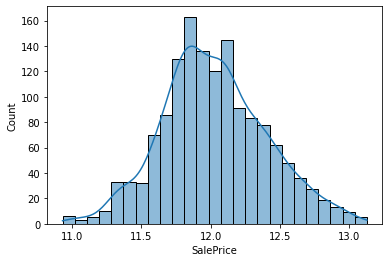

In [86]:
sns.histplot(target, kde = True)

In [87]:
x, y = df_train.to_numpy(), target.to_numpy()

In [88]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=.3, random_state=1)
x_train.shape,  x_valid.shape, y_train.shape, y_valid.shape

#Normalizaton
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_valid_norm = scaler.transform(x_valid)

In [89]:
#sns.histplot(pd.DataFrame(x_train_norm), kde = True)

In [90]:
x_train.shape,  x_valid.shape, y_train.shape, y_valid.shape
df_train.shape

(1443, 270)

x_train, x_valid, y_train, y_valid = train_valid_split(x, y, test_size=.3, random_state=1)
x_train.shape,  x_valid.shape, y_train.shape, y_valid.shape

from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
x_train_norm = scaler.fit_transform(x_train)
x_valid_norm = scaler.transform(x_valid)

# GBR

In [91]:
GBR = GradientBoostingRegressor()

# будут рассмотрены все возможные комбинаци этих значений
param_grid = {
    'loss': ['ls', 'lad','huber'],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [1000],
    'max_depth': [3],
    'max_leaf_nodes': [15, 16],
    'max_features': ['log2', 'sqrt'],
    'tol': [0.005],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [4, 3]
}

# создаем объект
cv = GridSearchCV(
    estimator=GBR,
    param_grid=param_grid,
    scoring=make_scorer(lambda t,p: mean_squared_error(t,p)**.5, greater_is_better=False),
    return_train_score=True,
    #refit=True,
    cv=5, # количество фолдов
    verbose=4, # сколько печатать сообщений
    n_jobs=-1, # насколько параллелельно считаем
)

In [92]:
cv.fit(x_train_norm, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'loss': ['ls', 'lad', 'huber'], 'max_depth': [3],
                         'max_features': ['log2', 'sqrt'],
                         'max_leaf_nodes': [15, 16], 'min_samples_leaf': [4, 5],
                         'min_samples_split': [4, 3], 'n_estimators': [1000],
                         'tol': [0.005]},
             return_train_score=True,
             scoring=make_scorer(<lambda>, greater_is_better=False), verbose=4)

In [98]:
cv.best_params_, cv.best_score_

({'learning_rate': 0.05,
  'loss': 'huber',
  'max_depth': 3,
  'max_features': 'log2',
  'max_leaf_nodes': 16,
  'min_samples_leaf': 4,
  'min_samples_split': 3,
  'n_estimators': 1000,
  'tol': 0.005},
 -0.11932728295566104)

In [99]:
pd.DataFrame(cv.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_loss', 'param_max_depth',
       'param_max_features', 'param_max_leaf_nodes', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_n_estimators', 'param_tol', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [100]:
pd.DataFrame(cv.cv_results_)[['mean_train_score', 'mean_test_score', 'std_test_score', 'params']].sort_values('mean_test_score', ascending = False)

,mean_train_score,mean_test_score,std_test_score,params
85,-0.065604,-0.119327,0.003489,"{'learning_rate': 0.05, 'loss': 'huber', 'max_..."
92,-0.058877,-0.119650,0.004844,"{'learning_rate': 0.05, 'loss': 'huber', 'max_..."
61,-0.050505,-0.120168,0.005074,"{'learning_rate': 0.05, 'loss': 'ls', 'max_dep..."
94,-0.061126,-0.120273,0.004259,"{'learning_rate': 0.05, 'loss': 'huber', 'max_..."
93,-0.058645,-0.120468,0.004196,"{'learning_rate': 0.05, 'loss': 'huber', 'max_..."
...,...,...,...,...
22,-0.119650,-0.138937,0.001566,"{'learning_rate': 0.01, 'loss': 'lad', 'max_de..."
21,-0.118175,-0.139074,0.001518,"{'learning_rate': 0.01, 'loss': 'lad', 'max_de..."
18,-0.119712,-0.139483,0.002869,"{'learning_rate': 0.01, 'loss': 'lad', 'max_de..."
20,-0.118305,-0.139785,0.002411,"{'learning_rate': 0.01, 'loss': 'lad', 'max_de..."


# Kaggle

In [101]:
x_test_kag = df_test.to_numpy()
x_test_norm = scaler.transform(x_test_kag)

In [102]:
x_test_kag.shape

(1459, 270)

In [103]:
np.e**cv.best_estimator_.predict(x_test_norm)

array([121988.37038602, 155879.23287129, 187030.97539253, ...,
       149326.93588936, 129350.83433736, 217593.92281843])

In [104]:
df_sample['SalePrice'] = np.e**cv.best_estimator_.predict(x_test_norm)

In [105]:
df_sample.to_csv('house_prices_kag_boost3_wo_out_05%.csv',columns = ['Id','SalePrice'],index=False)

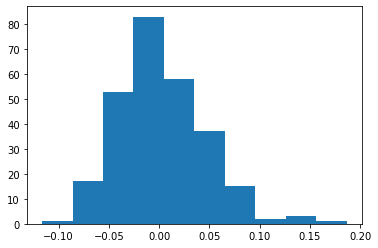

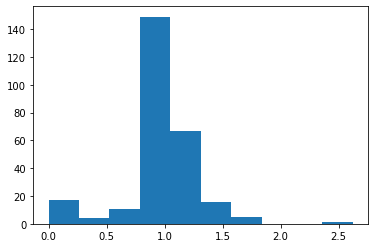

In [106]:
plt.hist(x_test_norm.mean(axis=0));
plt.show()
plt.hist(x_test_norm.std(axis=0));

In [22]:
x_test_norm.std(axis=0)[218]

0.7012999029678173

# KNN

In [107]:
# Grid search + cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
# создаем объект, не задавая параметры. Можно задать параметры, которые не будет изменяться при GS
KNR = KNeighborsRegressor( )

# будут рассмотрены все возможные комбинаци этих значений
param_grid = {
    'n_neighbors': [3,5,7],
    'p': [1,2,3],
    'weights': ['uniform', 'distance'],
    'leaf_size':[9, 10] 
}

# создаем объект
cv_knn = GridSearchCV(
    estimator = KNR, 
    param_grid = param_grid,
    scoring = make_scorer(lambda t,p: mean_squared_log_error(t,p)**.5, greater_is_better=False), # метрика, которую будем *максимизировать*
    return_train_score= True,
    cv=5, #кол-во фолдов
    verbose = 4,
    n_jobs = -1, # насколько параллелельно считаем,
    refit=True
    )

In [25]:
cv_knn.fit(x_train_norm, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [9, 10], 'n_neighbors': [3, 5, 7],
                         'p': [1, 2, 3], 'weights': ['uniform', 'distance']},
             return_train_score=True,
             scoring=make_scorer(<lambda>, greater_is_better=False), verbose=4)

In [26]:
cv_knn.best_params_, cv_knn.best_score_

({'leaf_size': 9, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'},
 -0.01286081783041432)

In [326]:
cv_knn.best_estimator_, cv_knn.best_estimator_.predict

(KNeighborsRegressor(leaf_size=9, p=1, weights='distance'),
 <bound method KNeighborsRegressor.predict of KNeighborsRegressor(leaf_size=9, p=1, weights='distance')>)

In [27]:
print(f'''
    Score:
    train {mean_squared_error(y_train, cv_knn.predict(x_train_norm))**.5 :.2f}
    test {mean_squared_error(y_valid, cv_knn.predict(x_valid_norm))**.5 :.2f}  
''')


    Score:
    train 0.00
    test 0.17  

